# SPH

[![Google Collab Book](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tum-pbs/PhiFlow/blob/develop/examples/particles/SPH.ipynb)

This example runs a simple SPH simulation based on Müller et al., Particle-based fluid simulation for interactive applications, 2003.
The implementation is identical to the [corresponding example](https://github.com/NVIDIA/warp/blob/3ed2ceab824b65486c5204d2a7381d37b79fc314/warp/examples/core/example_sph.py) from Warp.

In [1]:
%pip install --quiet phiflow
from phi.torch.flow import *
from phi.physics import sph
# from phi.flow import *  # If JAX is not installed. You can use phi.torch or phi.tf as well.
from tqdm.notebook import trange

We begin by defining our domain and fluid settings. Particles spawn in the lower left corner to simulate a dam break.

<Figure size 216x216 with 1 Axes>

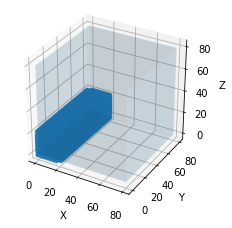

In [2]:
domain = Box(x=80, y=80, z=80)
smoothing_length = 0.8  # copied from warp, we would usually set desired_neighbors instead.
initial_positions = pack_dims(math.meshgrid(x=25, y=100, z=25), spatial, instance('particles')) * smoothing_length
initial_positions += 0.001 * smoothing_length * math.random_normal(initial_positions.shape)
particles = Sphere(initial_positions, volume=smoothing_length**3, radius_variable=False)
desired_neighbors = sph.expected_neighbors(particles.volume, smoothing_length, 3)

particle_mass = 0.01 * math.mean(particles.volume)
dt = 0.01 * smoothing_length
dynamic_visc = 0.025
damping_coef = -0.95
gravity = vec(x=0, y=0, z=-0.1)
pressure_normalization = -(45.0 * particle_mass) / (PI * smoothing_length**6)
viscous_normalization = (45.0 * dynamic_visc * particle_mass) / (PI * smoothing_length**6)

plot([domain, initial_positions], overlay='list', alpha=[.1, .4], size=(3, 3))

Next, we define the SPH update step.
The `sph.neighbor_graph` function builds a sparse connectivity matrix and evaluates the specified kernel `poly6`.
The neighbors of each particle are listed along the corresponding dual dimension.

In [3]:
@jit_compile
def sph_step(v: Field, dt=dt, isotropic_exp=20., base_density=1.):
    graph = sph.neighbor_graph(v.geometry, 'poly6', desired_neighbors=desired_neighbors, compute='kernel', domain=domain)
    # --- compute density and pressure ---
    rho = math.sum(graph.edges['kernel'], dual) * particle_mass  # this includes the density contribution from self
    pressure = isotropic_exp * (rho - base_density)
    nb_rho = rename_dims(rho, instance, dual)
    nb_pressure = rename_dims(pressure, instance, dual)
    distance_gaps = smoothing_length - graph.distances
    # --- pressure force ---
    avg_pressure = (graph.connectivity * pressure + nb_pressure) / (2 * nb_rho)
    pressure_force = -graph.unit_deltas * avg_pressure * distance_gaps ** 2
    # --- viscosity force ---
    dv = math.pairwise_differences(v.values, format=graph.edges)
    viscous_force = dv / nb_rho * distance_gaps
    # --- sum forces, integrate ---
    force = math.sum(pressure_normalization * pressure_force + viscous_normalization * viscous_force, dual)
    a = force / rho + gravity
    v += a * dt  # kick
    return v.shifted(dt * v.values)

@jit_compile
def apply_bounds(v: Field, damping_coef=-0.95) -> Field:
    clipped = math.clip(v.points, domain.lower, domain.upper)
    v = field.where(clipped == v.points, v, v * damping_coef)
    return v.shifted_to(clipped)

Let's run the simulation!

In [15]:
initial_state = Field(particles, vec(x=0, y=0, z=0), 0)
trj = iterate(lambda v: apply_bounds(sph_step(v)), batch(t=480), initial_state, substeps=int(32 / smoothing_length), range=trange)

  0%|          | 0/480 [00:00<?, ?it/s]

In [26]:
plot([domain, trj.points.t[::3]], overlay='list', alpha=[.1, .3], animate='t', size=(5, 5), frame_time=50)

We can also plot or animate 2D projections of the simulation.
This is much faster than plotting a 3D sphere for each particle with Matplotlib.

<Figure size 360x360 with 1 Axes>

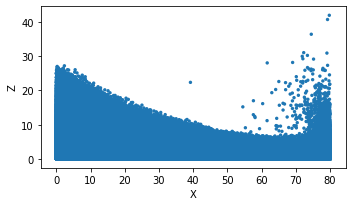

In [29]:
plot(trj.geometry.t[150]['x,z'], overlay='list', size=(5, 5), frame_time=50)